In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
scipy.__version__

'0.19.1'

In [3]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [4]:
import fastparquet
%time df=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 3.45 s, sys: 1.33 s, total: 4.78 s
Wall time: 4.78 s


In [5]:
df=df.loc[np.random.permutation(df.index)]
X=df.drop(['target','fold'],axis=1)
y=df['target']
trainx=X[y>=0]
trainy=y[y>=0]
testx=X[y<0]
folds=df[y>=0]['fold']
print trainx.shape,testx.shape,trainy.shape, len(folds),set(trainy)

(5203955, 50) (1378521, 50) (5203955,) 5203955 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20])


In [6]:
gc.collect()

9954

# cv

In [7]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [8]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [9]:
input_dim=X.shape[1]
input_dim

50

In [10]:
def categorical_mean_squared_error(y_true, y_pred):
    a_true=K.sum(y_true*K_CONST,-1)
    a_pred=K.sum(y_pred*K_CONST,-1)
    return K.mean(K.square(a_true-a_pred), axis=-1)

In [11]:
y.mean(),y.std(),K.floatx()

(3.4223003623560495, 3.4872334485676904, 'float32')

In [12]:
def cqwk_error(y_true, y_pred):
    M=K.constant(4.593761,dtype=tf.float32)
    y_true_zeromean=y_true-M
    y_pred_zeromean=y_pred-M
    covab=tf.reduce_mean(y_pred_zeromean*y_true_zeromean)
    vara=tf.reduce_mean(y_true_zeromean*y_true_zeromean)
    varb=tf.reduce_mean(y_pred_zeromean*y_pred_zeromean)
    return K.constant(-2,dtype=tf.float32)*covab/(vara+varb)
def epsilon_loss(y_true,y_pred,epsilon):
     return tf.reduce_mean(tf.maximum(0., tf.abs(y_pred-y_true)-epsilon))
def epsilon_squared_loss(y_true,y_pred,epsilon):
     return tf.reduce_mean(tf.maximum(0., tf.abs(y_pred-y_true)-epsilon)**2)

In [27]:
import uuid
class KerasModel:
    def __init__(self,X_train,y_train,X_valid,y_valid, params={}):
        #valid_idx=X_valid.index
        self.validation_data=(X_valid.values,y_valid.values)
        self.X_train,self.y_train=X_train.values,y_train.values
        self.name=str(uuid.uuid4())
        self.params=params
        self.this_loss=None
        print self.name,self.params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        if 'use_kernel' in params  and params['use_kernel']:
            model.add(KernelLayer(params['components'],params["normalization"],params['kernel'],
                                  params['gamma'],params['degree']))
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss='mean_squared_error'
            if params['metric']=="mean_squared_error":
                this_metrics=[metrics.mean_squared_error]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'cqwk_error':
            model.add(Dense(1,activation=None))
            this_loss=cqwk_error
            if params['metric']=="cqwk_error":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'epsilon_loss':
            epsilon = K.constant([params['epsilon']])
            model.add(Dense(1,activation=None))
            def this_loss(u,v):
                return epsilon_loss(u,v,epsilon)
            self.this_loss=this_loss
            if params['metric']=="epsilon_loss":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'epsilon_squared_loss':
            epsilon = K.constant([params['epsilon']])
            model.add(Dense(1,activation=None))
            def this_loss(u,v):
                return epsilon_squared_loss(u,v,epsilon)
            self.this_loss=this_loss            
            if params['metric']=="epsilon_squared_loss":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif  params['loss'] ==  'categorical_crossentropy':            
            model.add(Dense(21, activation='softmax'))
            this_loss='categorical_crossentropy'
            if params['metric']=="categorical_crossentropy":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif  params['loss'] ==  'categorical_mse':            
            model.add(Dense(21, activation='softmax'))
            this_loss=lambda u,v: categorical_mean_squared_error(u,v)
            if params['metric']=="categorical_mse":
                this_metrics=[categorical_mean_squared_error]
            else:
                raise Exception("unknown")                
        elif  params['loss'] ==  'categorical_mix':            
            model.add(Dense(21, activation='softmax'))
            this_loss=lambda u,v: 0.5*categorical_mean_squared_error(u,v)+losses.categorical_crossentropy(u,v)
            if params['metric']=="categorical_mix":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")                
                
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
          metrics=this_metrics)

        self.model=model
        return self
    def fit(self,epochs=200):
        params=self.params
        patience=params['patience']
        if params['loss'] ==  'categorical_crossentropy'        :
            self.y_train=keras.utils.to_categorical(self.y_train, num_classes=21)
            vx,vy=self.validation_data
            vy=keras.utils.to_categorical(vy, num_classes=21)
            self.validation_data=(vx,vy)
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        print "earlystopping on "+metric_name
        early_stopping = EarlyStopping(monitor='val_'+metric_name, patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     save_weights_only=False, mode='auto', period=1)

        batch_size=params['batch_size']
        history=self.model.fit(self.X_train, self.y_train, batch_size=batch_size,epochs=epochs, validation_data=self.validation_data, 
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return history
    def load_best(self):
        return keras.models.load_model(self.name,custom_objects={'cqwk_error':cqwk_error, 'this_loss':self.this_loss})

In [28]:
def make_tf_kernel(X,compoents, normalization, kernel='rbf',gamma=0.1,degree=3):
    components=K.constant(compoents,dtype=tf.float32)
    normalization=K.constant(normalization.T,dtype=tf.float32)
    if kernel=='rbf':
        X=K.expand_dims(X,axis=1)
        def f(x):
            d=x-compoents
            return K.exp(-gamma*K.sum((d**2),axis=1))
        embeded=K.map_fn(f,X,dtype=tf.float32)
        return tf.matmul(embeded,normalization)
    elif kernel=='polynomial':
        def f():
            xy=tf.matmul(X,tf.transpose(compoents))
            return tf.pow(gamma*xy+1,degree)
        embeded=f()
        return tf.matmul(embeded,normalization)
    elif kernel=='sigmoid':
        def f():
            xy=tf.matmul(X,tf.transpose(compoents))
            return tf.tanh(gamma*xy+1)
        embeded=f()
        return tf.matmul(embeded,normalization)    
    else:
        raise Exception("unknown")        

        
class KernelLayer(Layer):

    def __init__(self, components, normalization, kernel='rbf',gamma=0.1,degree=3,  **kwargs):
        assert kernel in ['rbf','sigmoid','polynomial']
        self.components=components
        self.n_components=components.shape[0]
        self.normalization=normalization        
        self.kernel=kernel
        self.gamma=gamma
        self.degree=degree
        super(KernelLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(KernelLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return make_tf_kernel(x,self.components,self.normalization,kernel=self.kernel,gamma=self.gamma,degree=self.degree)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)   

In [29]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [30]:
def make_model(i, X_train,y_train,X_valid,y_valid, parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    K_CONST=K.constant(np.array([range(21)]),dtype=tf.float32)
    a=KerasModel(X_train,y_train,X_valid,y_valid,parameter)
    a._make_model()
    h=a.fit()
    return a.load_best()


In [31]:
def train_once(fold):
    print fold
    X_train=trainx[(folds<>fold)]
    y_train=trainy[(folds<>fold)]
    X_valid=trainx[(folds==fold)]
    y_valid=trainy[(folds==fold)]

    regr = make_model(0, X_train,y_train,X_valid,y_valid, param)
    a= pd.DataFrame(regr.predict(testx.values),index=testx.index) 
    b=pd.DataFrame(regr.predict(X_valid.values),index=X_valid.index) 
    return a,b

def train():
    lst_valid=[]
    lst_test=[]
    for i in range(5):
        a,b=train_once(i)
        lst_test.append(a)
        lst_valid.append(b)
    return lst_valid,lst_test

In [32]:
param={'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 512,
 'dropout_rate': 0.0,
 'hidden_layer_sizes': (512, 512, 512),
 'input_dim': (50,),
 'l2': 0,
 'loss': 'categorical_crossentropy',
 'metric': 'categorical_crossentropy',
 'optimizer': 'adam',
 'epsilon':0.3,
 'patience': 5}

In [33]:
lst_valid,lst_test=train()

0
4cc1be4e-e68d-49cd-81a2-633cc8647cf4 {'dropout_rate': 0.0, 'optimizer': 'adam', 'epsilon': 0.3, 'activation': 'relu', 'batch_size': 512, 'patience': 5, 'loss': 'categorical_crossentropy', 'hidden_layer_sizes': (512, 512, 512), 'batch_normalization': False, 'l2': 0, 'input_dim': (50,), 'metric': 'categorical_crossentropy'}
earlystopping on categorical_crossentropy
Train on 4163591 samples, validate on 1040364 samples
Epoch 1/200
4163591/4163591 [==============================] - 66s 16us/step - loss: 1.8248 - categorical_crossentropy: 1.8248 - val_loss: 1.8119 - val_categorical_crossentropy: 1.8119
Epoch 2/200
4163591/4163591 [==============================] - 65s 16us/step - loss: 1.8090 - categorical_crossentropy: 1.8090 - val_loss: 1.8066 - val_categorical_crossentropy: 1.8066
Epoch 3/200
4163591/4163591 [==============================] - 65s 16us/step - loss: 1.8050 - categorical_crossentropy: 1.8050 - val_loss: 1.8043 - val_categorical_crossentropy: 1.8043
Epoch 4/200
4163591/416

Train on 4163358 samples, validate on 1040597 samples
Epoch 1/200
4163358/4163358 [==============================] - 66s 16us/step - loss: 1.8242 - categorical_crossentropy: 1.8242 - val_loss: 1.8110 - val_categorical_crossentropy: 1.8110
Epoch 2/200
4163358/4163358 [==============================] - 65s 16us/step - loss: 1.8082 - categorical_crossentropy: 1.8082 - val_loss: 1.8086 - val_categorical_crossentropy: 1.8086
Epoch 3/200
4163358/4163358 [==============================] - 65s 16us/step - loss: 1.8045 - categorical_crossentropy: 1.8045 - val_loss: 1.8064 - val_categorical_crossentropy: 1.8064
Epoch 4/200
4163358/4163358 [==============================] - 65s 16us/step - loss: 1.8024 - categorical_crossentropy: 1.8024 - val_loss: 1.8049 - val_categorical_crossentropy: 1.8049
Epoch 5/200
4163358/4163358 [==============================] - 65s 16us/step - loss: 1.8008 - categorical_crossentropy: 1.8008 - val_loss: 1.8029 - val_categorical_crossentropy: 1.8029
Epoch 6/200
4163358/4

Epoch 6/200
4163521/4163521 [==============================] - 71s 17us/step - loss: 1.7999 - categorical_crossentropy: 1.7999 - val_loss: 1.8012 - val_categorical_crossentropy: 1.8012
Epoch 7/200
4163521/4163521 [==============================] - 69s 17us/step - loss: 1.7988 - categorical_crossentropy: 1.7988 - val_loss: 1.7997 - val_categorical_crossentropy: 1.7997
Epoch 8/200
4163521/4163521 [==============================] - 74s 18us/step - loss: 1.7978 - categorical_crossentropy: 1.7978 - val_loss: 1.7997 - val_categorical_crossentropy: 1.7997
Epoch 9/200
4163521/4163521 [==============================] - 74s 18us/step - loss: 1.7969 - categorical_crossentropy: 1.7969 - val_loss: 1.7991 - val_categorical_crossentropy: 1.7991
Epoch 10/200
4163521/4163521 [==============================] - 70s 17us/step - loss: 1.7962 - categorical_crossentropy: 1.7962 - val_loss: 1.7995 - val_categorical_crossentropy: 1.7995
Epoch 11/200
4163521/4163521 [==============================] - 71s 17us/s

4162803/4162803 [==============================] - 77s 18us/step - loss: 1.7963 - categorical_crossentropy: 1.7963 - val_loss: 1.8011 - val_categorical_crossentropy: 1.8011
Epoch 11/200
4162803/4162803 [==============================] - 78s 19us/step - loss: 1.7956 - categorical_crossentropy: 1.7956 - val_loss: 1.7997 - val_categorical_crossentropy: 1.7997
Epoch 12/200
4162803/4162803 [==============================] - 78s 19us/step - loss: 1.7950 - categorical_crossentropy: 1.7950 - val_loss: 1.8002 - val_categorical_crossentropy: 1.8002
Epoch 13/200
4162803/4162803 [==============================] - 77s 18us/step - loss: 1.7944 - categorical_crossentropy: 1.7944 - val_loss: 1.8010 - val_categorical_crossentropy: 1.8010
Epoch 14/200
4162803/4162803 [==============================] - 77s 19us/step - loss: 1.7938 - categorical_crossentropy: 1.7938 - val_loss: 1.7994 - val_categorical_crossentropy: 1.7994
Epoch 15/200
4162803/4162803 [==============================] - 77s 19us/step - los

4162547/4162547 [==============================] - 65s 16us/step - loss: 1.7946 - categorical_crossentropy: 1.7946 - val_loss: 1.8025 - val_categorical_crossentropy: 1.8025
Epoch 13/200
4162547/4162547 [==============================] - 65s 16us/step - loss: 1.7940 - categorical_crossentropy: 1.7940 - val_loss: 1.8025 - val_categorical_crossentropy: 1.8025
Epoch 14/200
4162547/4162547 [==============================] - 65s 16us/step - loss: 1.7935 - categorical_crossentropy: 1.7935 - val_loss: 1.8012 - val_categorical_crossentropy: 1.8012
Epoch 15/200
4162547/4162547 [==============================] - 65s 16us/step - loss: 1.7928 - categorical_crossentropy: 1.7928 - val_loss: 1.8028 - val_categorical_crossentropy: 1.8028
Epoch 16/200
4162547/4162547 [==============================] - 65s 16us/step - loss: 1.7924 - categorical_crossentropy: 1.7924 - val_loss: 1.8018 - val_categorical_crossentropy: 1.8018
Epoch 17/200
4162547/4162547 [==============================] - 65s 16us/step - los

In [34]:
name='kerasclf0'

In [36]:
l1_test_pred=(reduce(lambda u,v:u+v,lst_test)/float(len(lst_test))).astype(np.float32) 
l1_test_pred.columns=[name+"_pred_"+str(i) for i in l1_test_pred.columns]

In [37]:
l1_train_pred=pd.concat(lst_valid).loc[trainx.index].astype(np.float32) 
l1_train_pred.columns=[name+"_pred_"+str(i) for i in l1_train_pred.columns]

In [38]:
l1_train_pred.shape,l1_test_pred.shape

((5203955, 21), (1378521, 21))

In [44]:
np.mean(np.argmax(l1_train_pred.values,axis=1)==trainy.values)

0.32498839824710246

In [48]:
expected_v=pd.Series(np.sum(l1_train_pred.values*np.array([range(21)]),1),index=l1_train_pred.index)

In [49]:
np.sqrt(r2_score(trainy,expected_v)),qwk_score(trainy,expected_v),mean_squared_error(trainy,expected_v)

(0.77133142165263269, 0.7421653089651262, 3.5762874142402237)

In [47]:
import cPickle as pickle
pickle.dump(l1_train_pred,open("../level1_train/{}_train_l1pred.pkl".format(name),'wb'))
pickle.dump(l1_test_pred,open("../level1_train/{}_test_l1pred.pkl".format(name),'wb'))

In [51]:
expected_test_v=pd.Series(np.sum(l1_test_pred.values*np.array([range(21)]),1),index=l1_test_pred.index)

0.697707180377 0.970730885733


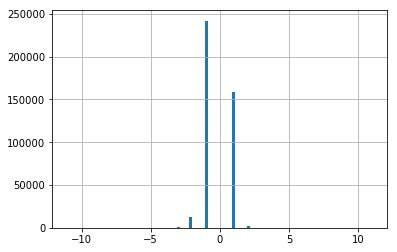

In [52]:
import cPickle as pickle
import numpy as np
a=clip_pred(expected_test_v)
b=clip_pred(pickle.load(open("../level1_train/ridge0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print np.mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)

0.901442923249 0.990859315165


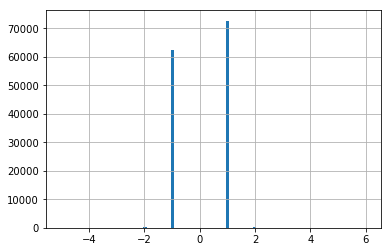

In [53]:
import cPickle as pickle
import numpy as np
a=clip_pred(pickle.load(open("../level1_train/kerasmlp0_test_l1pred.pkl")))
b=clip_pred(expected_test_v)
b=b.loc[a.index]
d=(a-b)
print np.mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)